In [1]:
from src.utils import data_load
import pandas as pd
import matplotlib.pyplot as plt
from src.s3_utils import pandas_from_csv_s3
from sklearn.model_selection import KFold
import re
import datetime
import seaborn as sns
import numpy as np
from collections import defaultdict
import os
import pickle
import json
import math
import random
import scipy.stats as stats

random.seed(0)
np.random.seed(0)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ugbs3qwk because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
wave_8_keys = {'birth'}
wave_7_keys = {'oura_sleep', 'oura_activity', 'oura_readiness', 'bodyport'}
wave_7_data = data_load(data_keys=wave_7_keys, wave=7)
wave_8_data = data_load(data_keys=wave_8_keys, wave=8)

In [3]:
wave_7_data['oura_sleep'].columns

Index(['id', 'user_id', 'identity_id', 'created_at', 'updated_at',
       'retrieved_at', 'subsource', 'event_date', 'awake', 'bedtime_end',
       'bedtime_end_delta', 'bedtime_start', 'bedtime_start_delta',
       'breath_average', 'deep', 'duration', 'efficiency', 'hr_5min',
       'hr_average', 'hr_lowest', 'hypnogram_5min', 'is_longest', 'light',
       'midpoint_at_delta', 'midpoint_time', 'onset_latency', 'period_id',
       'rem', 'restless', 'rmssd', 'rmssd_5min', 'score', 'score_alignment',
       'score_deep', 'score_disturbances', 'score_efficiency', 'score_latency',
       'score_rem', 'score_total', 'temperature_delta',
       'temperature_deviation', 'temperature_trend_deviation', 'timezone',
       'total', 'record_id', 'date'],
      dtype='object')

In [4]:
wave_7_data['oura_activity'].columns

Index(['id', 'user_id', 'identity_id', 'created_at', 'updated_at',
       'retrieved_at', 'subsource', 'event_date', 'average_met', 'cal_active',
       'cal_total', 'class_5min', 'daily_movement', 'day_end', 'day_start',
       'high', 'inactive', 'inactivity_alerts', 'low', 'medium', 'met_1min',
       'met_min_high', 'met_min_inactive', 'met_min_low', 'met_min_medium',
       'non_wear', 'rest', 'rest_mode_state', 'score',
       'score_meet_daily_targets', 'score_move_every_hour',
       'score_recovery_time', 'score_stay_active', 'score_training_frequency',
       'score_training_volume', 'steps', 'target_calories', 'target_km',
       'target_miles', 'timezone', 'to_target_km', 'to_target_miles', 'total',
       'record_id', 'date'],
      dtype='object')

In [62]:
wave_7_data['oura_readiness'].columns

Index(['id', 'user_id', 'identity_id', 'created_at', 'updated_at',
       'retrieved_at', 'subsource', 'event_date', 'period_id',
       'rest_mode_state', 'score', 'score_activity_balance',
       'score_hrv_balance', 'score_previous_day', 'score_previous_night',
       'score_recovery_index', 'score_resting_hr', 'score_sleep_balance',
       'score_temperature', 'record_id', 'date'],
      dtype='object')

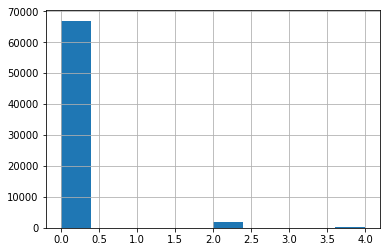

In [70]:
wave_7_data['oura_readiness']['rest_mode_state'].hist()

In [9]:
oura_sleep_list = ['awake', \
       'bedtime_end_delta', 'bedtime_start_delta',
       'breath_average', 'deep', 'duration', 'efficiency', \
       'hr_average', 'hr_lowest', 'light', \
       'midpoint_at_delta', 'midpoint_time', 'onset_latency', \
       'rem', 'restless', 'rmssd', 'score', \
       'score_deep', 'score_disturbances', 'score_efficiency', 'score_latency', \
       'score_rem', 'score_total', 'temperature_delta', \
       'temperature_deviation', 'temperature_trend_deviation', \
       'total']

In [53]:
oura_activity_list = ['average_met', 'cal_active', \
       'cal_total', 'daily_movement', 'low', 'medium', \
       'met_min_low', 'met_min_medium', \
       'non_wear', 'rest', \
       'steps', 'target_calories', 'target_km', \
       'target_miles', 'to_target_km', 'to_target_miles', 'total'] 

In [72]:
oura_readiness_list = ['score', 'score_activity_balance', \
       'score_hrv_balance', 'score_previous_night', \
       'score_recovery_index', 'score_resting_hr', 'score_sleep_balance', \
       'score_temperature'] 

In [18]:
def fill_in_missing_dates(df, date_col_name = 'date', start_date=None, end_date=None, fill_val = np.nan, date_format='%Y-%m-%d'):
    df.set_index(date_col_name,drop=True,inplace=True)
    df.index = pd.to_datetime(df.index, format = date_format)
    idx = pd.date_range(start_date, end_date)
    # print('missing_dates are',idx.difference(df.index))
    df=df.reindex(idx,fill_value=fill_val)
    return df

In [19]:
def process_wearables_data(birth_df, oura_df, oura_list, before_days=30, after_day=7, adherence=1):
    processed_data = defaultdict(list,{ k:[] for k in oura_sleep_list + ['user_id', 'missingness'] })
    processed_data_total = []
    
    for uid in birth_df['user_id'].unique():
        df = oura_df.loc[oura_df['user_id'] == uid].sort_values(by='date')
        if len(df) > 0:
            birth_date = birth_df.loc[birth_df['user_id'] == uid]['birth_date'].tolist()[0]
            birth_scheduled = birth_df.loc[birth_df['user_id'] == uid]['birth_scheduled'].tolist()[0]
            if birth_scheduled == 2:
                birth_date = datetime.datetime.strptime(birth_date, '%Y-%M-%d').date()
                start_date = birth_date + pd.to_timedelta(-before_days + 1, unit='d')
                end_date = birth_date + pd.to_timedelta(after_days, unit='d')
                df = df[(df['date'] >= start_date)]
                df = df[(df['date'] <= end_date)]
                if len(df) >= round((before_days + after_days) * adherence):
                    # print(df['date'].min(), df['date'].max(), birth_date)
                    # if len(df) != before_days + after_days:
                    processed_data['missingness'].append(round((len(df) / (before_days + after_days)), 2))
                    df=fill_in_missing_dates(df, date_col_name='date', start_date=start_date, end_date=end_date)
                    for col in oura_list:
                        processed_data[col].append(df[col].tolist())
                    df = df.interpolate(method='linear', limit_direction='forward', axis=0)
                    df = df.ffill(axis=0)
                    processed_data['user_id'].append(uid)
                    processed_data_total.append(df[oura_list].to_numpy())
    processed_data_total = np.stack(processed_data_total) # num of people x days x features
    return processed_data_total

In [20]:
def plot_feature_correlation(data):
    """
    Given a matrix with shape of [num people (n) x num days (m) x num features (p)],
    calculate pairwise feature on a population level.
    return a correlation matrix (p x p)
    """
    # data = data[~np.isnan(data)]
    corr_matrix = np.zeros((data.shape[2], data.shape[2]))
    for person_i in range(data.shape[0]):
        corr_matrix = corr_matrix + np.corrcoef(data[person_i].T)
    corr_matrix =  corr_matrix / data.shape[0]
    
    return corr_matrix


In [21]:
birth_df = wave_8_data['birth']
oura_df = wave_7_data['oura_sleep'][oura_sleep_list + ['user_id', 'date']]
before_days = 30
after_days = 7
processed_data_oura_sleep = process_wearables_data(birth_df, oura_df, oura_sleep_list, before_days=30, after_day=7, adherence=1)
corr_matrix_oura_sleep = plot_feature_correlation(processed_data_oura_sleep)

In [60]:
uncorrelated_oura = np.where(np.abs(corr_matrix_oura_sleep).round(2) == np.abs(corr_matrix_oura_sleep).round(2).min())
low_corr_cell_oura_sleep = [oura_sleep_list[x] for x in list(set(uncorrelated_oura[0]) | set(uncorrelated_oura[1]))]
low_corr_mean_oura_sleep = [oura_sleep_list[x] for x in np.argpartition(np.abs(corr_matrix_oura_sleep.mean(axis=0)), 3)[:5]]
print(f'low_corr_mean_oura_sleep: {low_corr_mean_oura_sleep}')
print(f'low_corr_cell_oura_sleep: {low_corr_cell_oura_sleep}')

low_corr_mean_oura_sleep: ['rmssd', 'awake', 'midpoint_at_delta', 'onset_latency', 'hr_lowest']
low_corr_cell_oura_sleep: ['bedtime_end_delta', 'bedtime_start_delta', 'breath_average', 'efficiency', 'hr_average', 'hr_lowest', 'light', 'midpoint_time', 'score_disturbances', 'score_latency', 'score_rem', 'temperature_delta', 'temperature_deviation', 'temperature_trend_deviation']


In [32]:
matrix = np.triu(np.ones_like(corr_matrix_oura_sleep))

fig = plt.figure(figsize=(20,20), dpi = 480)
sns.heatmap(corr_matrix_oura_sleep, annot = True, fmt = '.2f', xticklabels=oura_sleep_list, yticklabels=oura_sleep_list, cmap='vlag', mask=matrix)
plt.title('Feature Correlation - Oura Sleep')
plt.savefig('/repos/Delivery-Readiness/results/correlation/oura_sleep_feature_correlation_beforeday30_afterday7.png')

In [54]:
birth_df = wave_8_data['birth']
oura_df = wave_7_data['oura_activity'][oura_activity_list + ['user_id', 'date']]
before_days = 30
after_days = 7
processed_data_oura_activity = process_wearables_data(birth_df, oura_df, oura_activity_list, before_days=30, after_day=7, adherence=1)
corr_matrix_oura_activity = plot_feature_correlation(processed_data_oura_activity)

In [59]:
uncorrelated_oura = np.where(np.abs(corr_matrix_oura_activity).round(2) == np.abs(corr_matrix_oura_activity).round(2).min())
low_corr_cell_oura_activity = [oura_activity_list[x] for x in list(set(uncorrelated_oura[0]) | set(uncorrelated_oura[1]))]
low_corr_mean_oura_activity = [oura_activity_list[x] for x in np.argpartition(np.abs(corr_matrix_oura_activity.mean(axis=0)), 3)[:5]]
print(low_corr_mean_oura_activity)
print(low_corr_cell_oura_activity)

['rest', 'non_wear', 'to_target_miles', 'to_target_km', 'target_calories']
['average_met', 'cal_total', 'target_calories', 'target_km', 'target_miles']


In [56]:
matrix = np.triu(np.ones_like(corr_matrix_oura_activity))

fig = plt.figure(figsize=(20,20), dpi = 480)
sns.heatmap(corr_matrix_oura_activity, annot = True, fmt = '.2f', xticklabels=oura_activity_list, yticklabels=oura_activity_list, cmap='vlag', mask=matrix)
plt.title('Feature Correlation - Oura Activity')
plt.savefig('/repos/Delivery-Readiness/results/correlation/oura_activity_feature_correlation_beforeday30_afterday7.png')

In [73]:
birth_df = wave_8_data['birth']
oura_df = wave_7_data['oura_readiness'][oura_readiness_list + ['user_id', 'date']]
before_days = 30
after_days = 7
processed_data_oura_readiness = process_wearables_data(birth_df, oura_df, oura_readiness_list, before_days=30, after_day=7, adherence=1)
corr_matrix_oura_readiness = plot_feature_correlation(processed_data_oura_readiness)

In [74]:
corr_matrix_oura_readiness

array([[ 1.        ,  0.12819173,  0.37702725,  0.61098127,  0.42459986,
         0.5282223 ,  0.59579023,  0.11758725],
       [ 0.12819173,  1.        , -0.08405319, -0.0108214 ,  0.05305099,
        -0.02715236, -0.03453229,  0.0466423 ],
       [ 0.37702725, -0.08405319,  1.        , -0.00983003, -0.05401017,
         0.27002184,  0.05270018,  0.02386919],
       [ 0.61098127, -0.0108214 , -0.00983003,  1.        ,  0.25312079,
         0.0319975 ,  0.42567477,  0.04783765],
       [ 0.42459986,  0.05305099, -0.05401017,  0.25312079,  1.        ,
        -0.05308737,  0.21165669,  0.11031929],
       [ 0.5282223 , -0.02715236,  0.27002184,  0.0319975 , -0.05308737,
         1.        ,  0.12079444,  0.08366761],
       [ 0.59579023, -0.03453229,  0.05270018,  0.42567477,  0.21165669,
         0.12079444,  1.        ,  0.08105216],
       [ 0.11758725,  0.0466423 ,  0.02386919,  0.04783765,  0.11031929,
         0.08366761,  0.08105216,  1.        ]])

In [75]:
uncorrelated_oura = np.where(np.abs(corr_matrix_oura_readiness).round(2) == np.abs(corr_matrix_oura_readiness).round(2).min())
low_corr_cell_oura_readiness = [oura_readiness_list[x] for x in list(set(uncorrelated_oura[0]) | set(uncorrelated_oura[1]))]
low_corr_mean_oura_readiness = [oura_readiness_list[x] for x in np.argpartition(np.abs(corr_matrix_oura_readiness.mean(axis=0)), 3)[:5]]
print(low_corr_mean_oura_readiness)
print(low_corr_cell_oura_readiness)

['score_activity_balance', 'score_hrv_balance', 'score_temperature', 'score_recovery_index', 'score_resting_hr']
['score_activity_balance', 'score_hrv_balance', 'score_previous_night']


In [69]:
matrix = np.triu(np.ones_like(corr_matrix_oura_readiness))

fig = plt.figure(figsize=(20,20), dpi = 480)
sns.heatmap(corr_matrix_oura_readiness, annot = True, fmt = '.2f', xticklabels=oura_readiness_list, yticklabels=oura_readiness_list, cmap='vlag', mask=matrix)
plt.title('Feature Correlation - Oura Readiness')
plt.savefig('/repos/Delivery-Readiness/results/correlation/oura_readiness_feature_correlation_beforeday30_afterday7.png')